# Metrics and Evaluation - California Housing Dataset

In [1]:
from sklearn.datasets import fetch_california_housing

x, y = fetch_california_housing(return_X_y=True, as_frame=True)

x.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [2]:
x.info()

<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


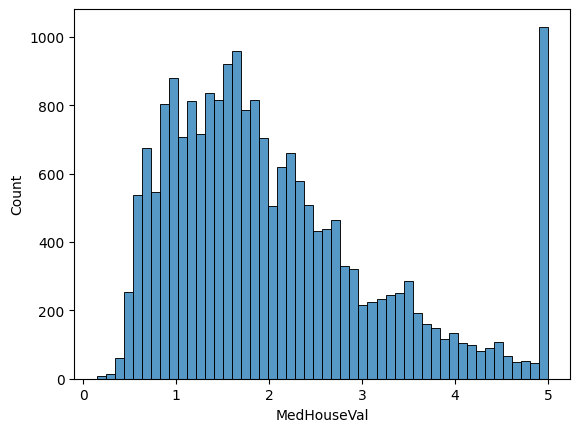

In [3]:
import seaborn as sns

sns.histplot(y, bins=50)

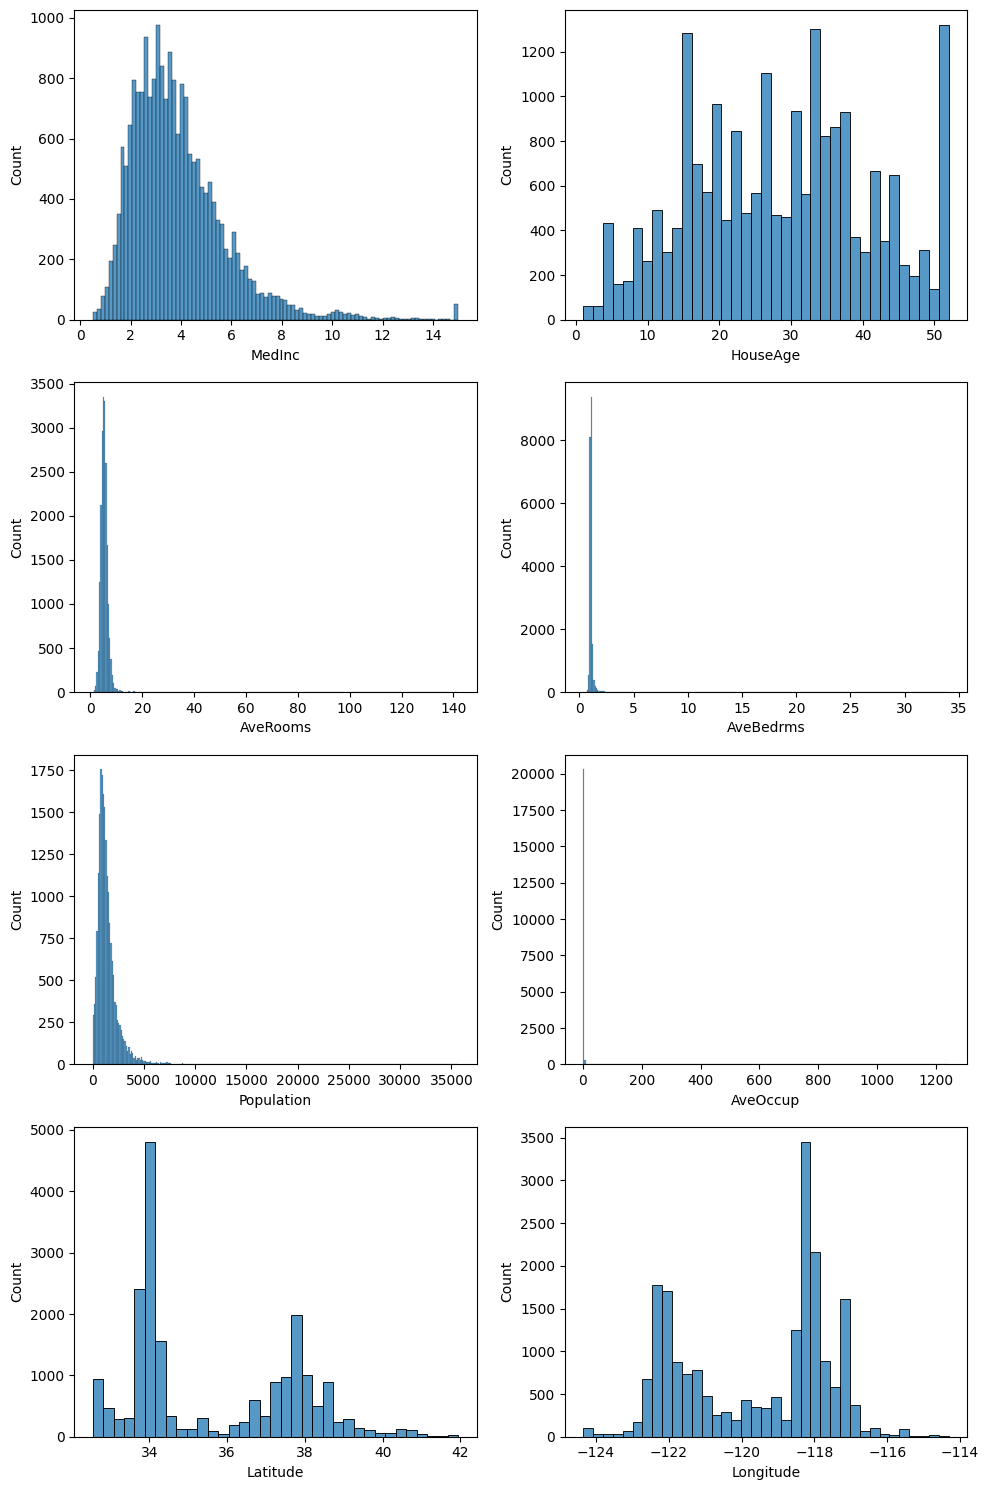

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(10, 15))

for ax, col in zip(axs.ravel(), x.columns):
    sns.histplot(x[col], ax=ax)

plt.tight_layout()

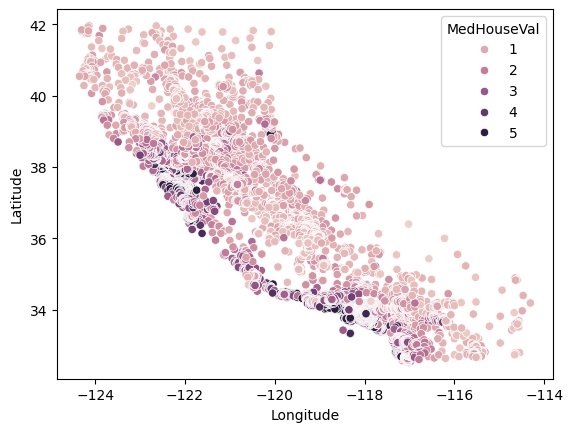

In [5]:
sns.scatterplot(x=x["Longitude"], y=x["Latitude"], hue=y)

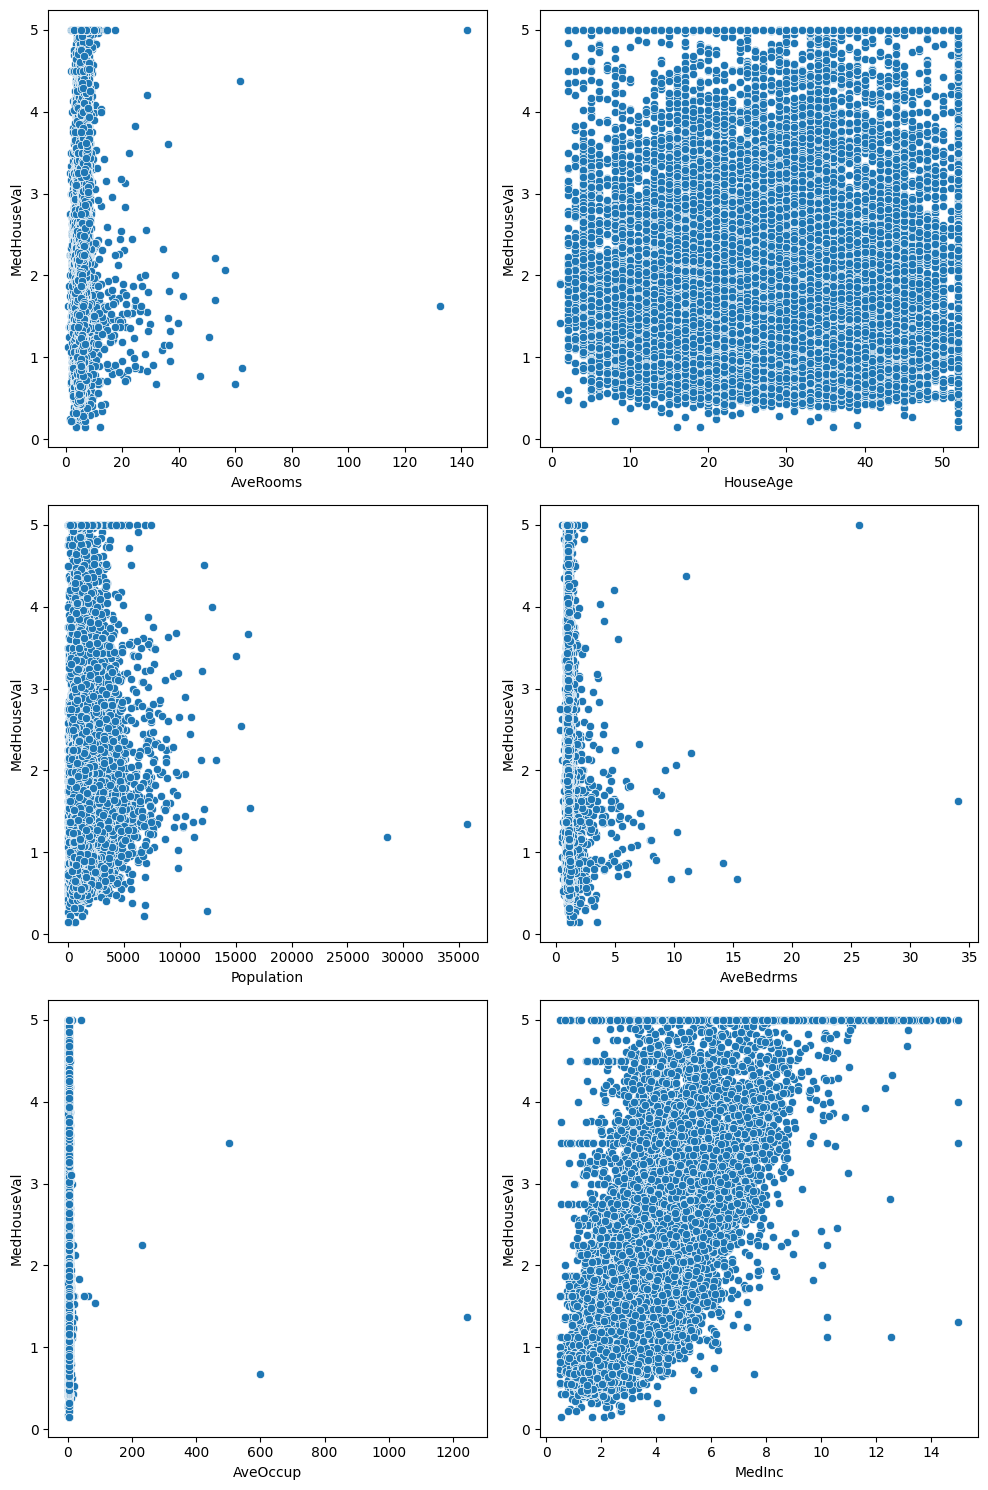

In [6]:
cols = set(x.columns) - {"Longitude", "Latitude"}

fig, axs = plt.subplots(3, 2, figsize=(10, 15))

for ax, col in zip(axs.ravel(), cols):
    sns.scatterplot(x=x[col], y=y, ax=ax)

plt.tight_layout()

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_testval, y_train, y_testval = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_testval, y_testval, test_size=0.5, random_state=42)

In [8]:
# Cap outliers based on IQR
Q1 = x_train.quantile(0.25)
Q3 = x_train.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

x_train_capped = x_train.copy()
x_test_capped = x_test.copy()
x_val_capped = x_val.copy()

for col in cols:
    x_train_capped[col] = x_train[col].clip(lower=lower_bound[col], upper=upper_bound[col])
    x_test_capped[col] = x_test[col].clip(lower=lower_bound[col], upper=upper_bound[col])
    x_val_capped[col] = x_val[col].clip(lower=lower_bound[col], upper=upper_bound[col])

x_train = x_train_capped
x_test = x_test_capped
x_val = x_val_capped

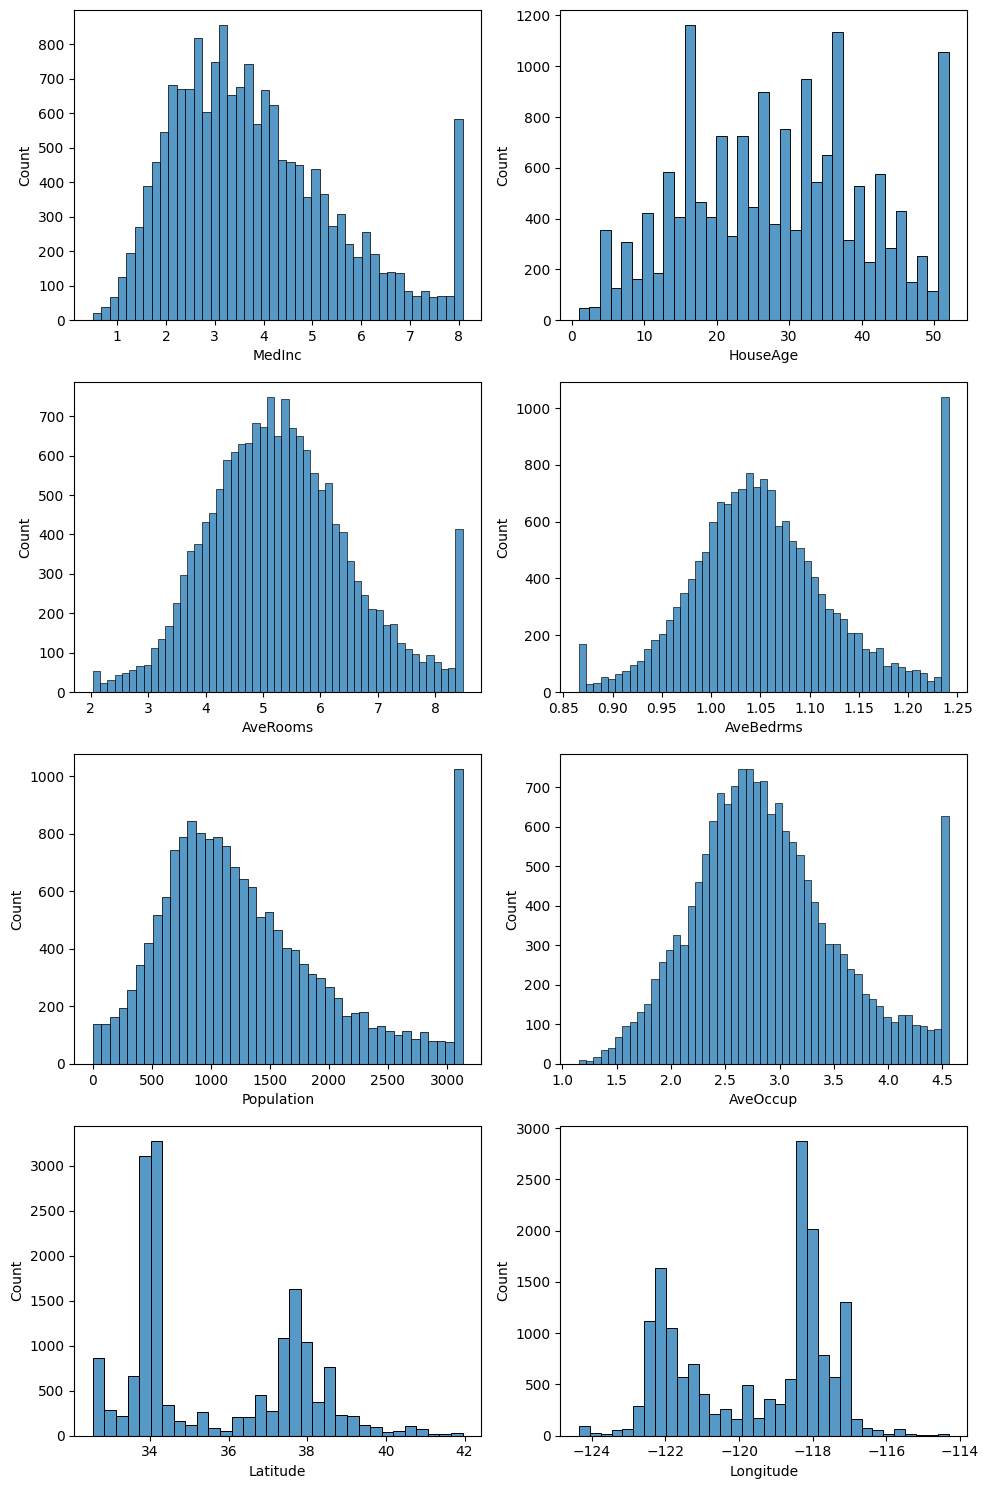

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(10, 15))

for ax, col in zip(axs.ravel(), x_train.columns):
    sns.histplot(x_train[col], ax=ax)

plt.tight_layout()

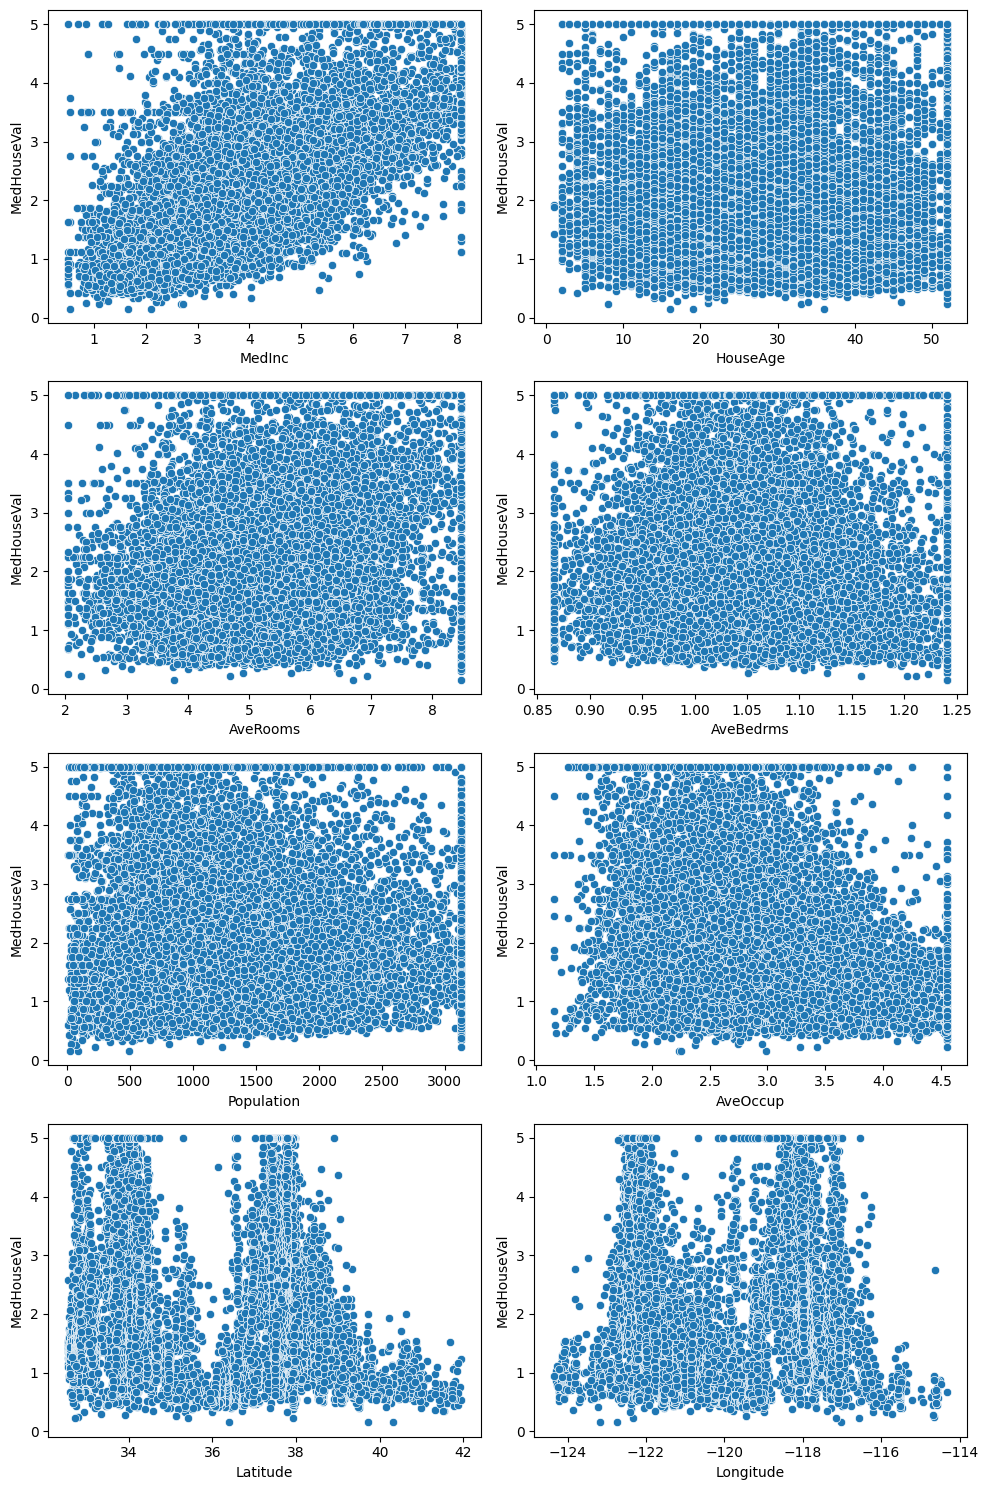

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(10, 15))

for ax, col in zip(axs.ravel(), x_train.columns):
    sns.scatterplot(x=x_train[col], y=y, ax=ax)

plt.tight_layout()

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

preprocessing = make_pipeline(
    ColumnTransformer(transformers=[
        ("num", MinMaxScaler(), x.columns)
    ])
)

In [12]:
x_train_processed = preprocessing.fit_transform(x_train)
x_test_processed = preprocessing.transform(x_test)
x_val_processed = preprocessing.transform(x_val)

In [13]:
x_train_processed

array([[0.36393308, 0.62745098, 0.46288192, ..., 0.7459508 , 0.01702128,
        0.72908367],
       [0.4368463 , 0.94117647, 0.3783391 , ..., 0.17213852, 0.12978723,
        0.61653386],
       [0.48218463, 0.05882353, 0.56048662, ..., 0.46147057, 0.22446809,
        0.38545817],
       ...,
       [0.32104761, 0.68627451, 0.3026969 , ..., 0.6402926 , 0.15744681,
        0.59462151],
       [0.68829073, 0.2745098 , 0.67694465, ..., 0.59530398, 0.53510638,
        0.23804781],
       [0.27371798, 1.        , 0.21193442, ..., 0.28098483, 0.55531915,
        0.19223108]], shape=(16512, 8))

## Model Training and Evaluation

In [14]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train_processed, y_train)
model

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error


def evaluate_model(model, x, y):
    y_pred = model.predict(x)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    return {"MAE": mae, "MSE": mse, "R²": r2, "RMSE": rmse}

In [16]:
import pandas as pd

train_metrics = evaluate_model(model, x_train_processed, y_train)
test_metrics = evaluate_model(model, x_test_processed, y_test)

metrics_df = pd.DataFrame({"Train": train_metrics, "Test": test_metrics})
metrics_df.T

,MAE,MSE,R²,RMSE
Train,0.492680,0.437935,0.672395,0.661767
Test,0.503701,0.472593,0.641096,0.687454


In [17]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(50, 50), solver="adam")

model.fit(x_train_processed, y_train)

train_metrics = evaluate_model(model, x_train_processed, y_train)
test_metrics = evaluate_model(model, x_test_processed, y_test)

metrics_df = pd.DataFrame({"Train": train_metrics, "Test": test_metrics})
metrics_df.T

,MAE,MSE,R²,RMSE
Train,0.344071,0.251296,0.812013,0.501295
Test,0.359202,0.284462,0.783969,0.533350


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50)],
    "solver": ["adam", "lbfgs"],
    "alpha": [0.0001, 0.001, 0.01],
}

grid_search = GridSearchCV(
    MLPRegressor(),
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",)

In [19]:
grid_search.fit(x_train_processed, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",MLPRegressor()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'alpha': [0.0001, 0.001, ...], 'hidden_layer_sizes': [(50,), (100,), ...], 'solver': ['adam', 'lbfgs']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candida

In [20]:
grid_search.best_params_

{'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}

In [21]:
model = grid_search.best_estimator_

train_metrics = evaluate_model(model, x_train_processed, y_train)
test_metrics = evaluate_model(model, x_test_processed, y_test)

metrics_df = pd.DataFrame({"Train": train_metrics, "Test": test_metrics})
metrics_df.T

,MAE,MSE,R²,RMSE
Train,0.350475,0.270514,0.797637,0.520110
Test,0.361017,0.293278,0.777274,0.541551


In [22]:
val_metrics = evaluate_model(model, x_val_processed, y_val)
val_metrics

{'MAE': 0.3604550992008323,
 'MSE': 0.28642459634211664,
 'R²': 0.7802427043241614,
 'RMSE': 0.5351865061285801}